In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import EnvironmentNetwork
from src.runner import Runner
import random
import json

In [2]:
style.use('seaborn-white')

# Setting the parameters

In [3]:
parameters = {
    # general simulation parameters
    "time": 150,
    "number_of_agents": 500,
    "monte_carlo_runs": 1,
    "high_performance": False,
    # specific simulation parameters
    "share_inital_agents_infected": 0.05, # percentage of agents infected randomly at the start of the simulation
    "highest_density_neighbourhood": 0.4, # percentage of nodes the highest density neighbourhoods has compared to caveman graph
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 20, # average number of days agents are in critical condition
    "health_system_capacity": 0.0028, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.05, # amount of agents that an agent might choose to travel to
    # agent parameters
    "probability_transmission": 0.20, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.25, # should be estimated to replicate travel data 
    "probability_critical": 0.19, # probability that an agent enters a critical stage of the disease SOURCE: Spycharlsky et al. 2020, & Zhou et al. 2020
    "probability_to_die": 0.28, # base probability to die for an agent in the critical stage SOURCE: Zhou et al. 2020
    "probability_susceptible": 0.0001, # probability that the agent will again be susceptible after having recovered
}

Store parameters in JSON file.

In [4]:
with open('parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

# Generate neighbourhood data using Ward data from Cape Town

In [5]:
population = pd.read_csv('population.csv')

In [6]:
population.head(3)

,WardID,Population,Area,Density,lon,lat
0,19100001,26434.07345,27213.359916,0.971364,18.612025,-33.857307
1,19100002,29914.18993,9222.458013,3.243624,18.422324,-34.069837
2,19100003,25735.62250,10891.277732,2.362957,18.476290,-34.048938


Because the amount of agents are less than in the actual population of Cape Town, we filter some wards so that all of them are at least populated with an agent. Therefore, we calculate the smallest size of a neighbourhood should have as follows.

In [7]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']

Next, we tranform the neighbourhoods to a list format that feeds into the model. 

In [8]:
neighbourhood_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        neighbourhood_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                            'Density': population['Density'].iloc[i],
                                                            'lon': population['lon'].iloc[i],
                                                            'lat': population['lat'].iloc[i]}])

If you want to do a smaller trial run of the model you can further limit the amount of neighbourhoods by setting the following parameter. 

In [9]:
max_neighbourhoods = len(neighbourhood_data)

In [10]:
with open('neighbourhood_data.json', 'w') as outfile:
    json.dump(neighbourhood_data[:max_neighbourhoods], outfile)

The next step is to either run the model in the SABCoModel.py file or run it here in the notebook. When running it in the notebook the initialization starts here. 

# Initialization

In [11]:
environment = EnvironmentNetwork(1, parameters, neighbourhood_data)

# Simulation

In [12]:
runner = Runner()
runner.do_run(environment, 1)

### Save network data

In [13]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "measurement/network_time{}.graphml".format(idx))

### Read data 

In [14]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/network_time{}.graphml".format(idx), node_type=int))

## Draw

In [15]:
pos = nx.spring_layout(infection_states[0])

In [16]:
def plot_model(t):
    network = infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [17]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=149), Output()), _dom_classes=('widget-i…

<function __main__.plot_model(t)>

Graph

In [18]:
susceptible_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot.append((recovered / float(len(network)))  * population['Population'].sum())

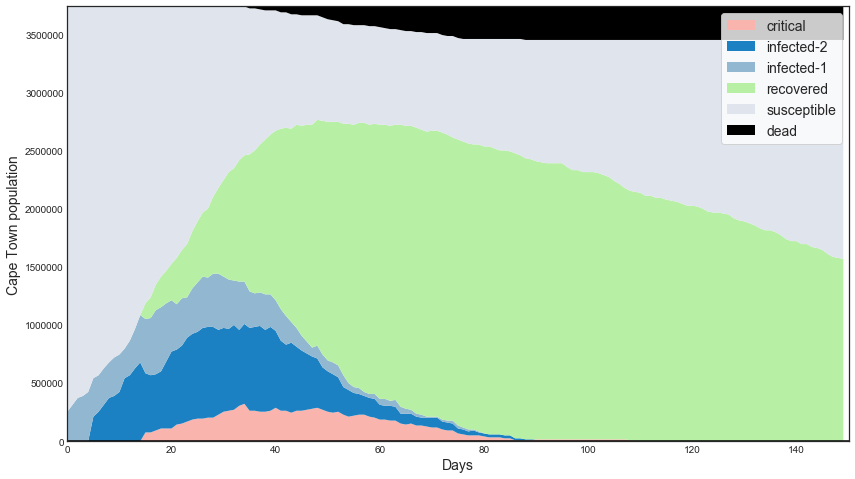

In [19]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

fig.savefig('measurement/the_curve.png')